In [ ]:
# librosa package requires Python version < 3.13

In [ ]:
# !pip install -r requirements.txt

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import IPython.display as ipd
import librosa
import librosa.display
import deeplake

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout

Define or load a signal and display its spectrogram.

In [42]:
Fs = 8000
N = 10000
t = np.arange(0, N/Fs, 1/Fs) # interval is [start,stop)
data = 0.15*np.sin(2*np.pi*600*t) + 0.4*np.sin(2*np.pi*1500*t) + 0.2*np.sin(2*np.pi*2000*t)
fig,ax = plt.subplots()
ax.plot(t, data, color='rebeccapurple') 
ax.set_title("Signal")
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Amplitude")
ax.set_xlim(0, 0.02)
plt.show() 

In [43]:
audio2 = data
audio2 = audio2.astype(np.float32)/32767.0
audio2 = (0.9/max(audio2))*audio2
audio2 = audio2[0:1999999]
ipd.Audio(audio2,rate=Fs)

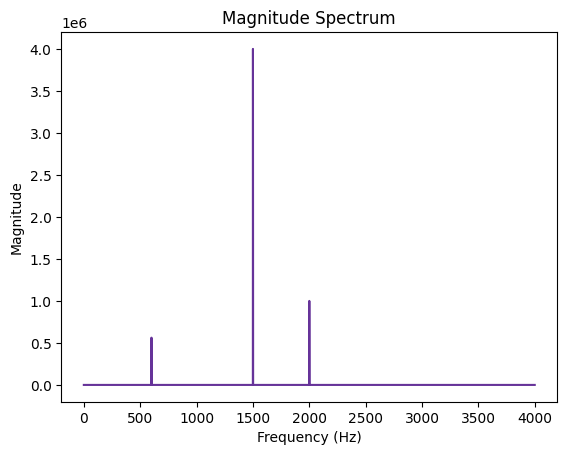

In [44]:
ft = np.fft.fft(data)
ft = ft[:int(N/2)]
freq = np.fft.fftfreq(N)
freq = freq[:int(N/2)]

fig,ax = plt.subplots()
ax.plot(freq*Fs, ft.real**2 + ft.imag**2, color='rebeccapurple')
ax.set_title("Magnitude Spectrum")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Magnitude")
plt.show()

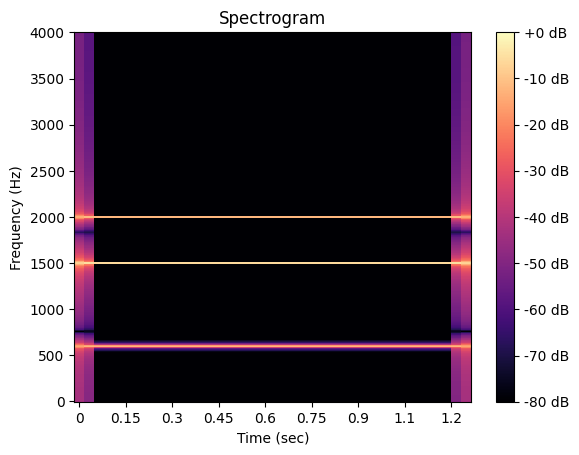

In [45]:
data = data.astype(float)
stft_data = librosa.stft(data, n_fft=1024, hop_length=256) 
stft_db = librosa.amplitude_to_db(np.abs(stft_data), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(stft_db, x_axis='time', y_axis='linear', n_fft=1024, hop_length=256, sr=Fs,ax=ax)
ax.set(title='Spectrogram')
fig.gca().set_xlabel("Time (sec)")
fig.gca().set_ylabel("Frequency (Hz)")
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [46]:
data, Fs = librosa.load("C_major.wav",sr=None) # mono wav file stored in same directory as .ipynb file
audio2 = data
audio2=audio2.astype(np.float32)/32767.0
audio2=(0.9/max(audio2))*audio2
audio2=audio2[0:1999999]
ipd.Audio(audio2,rate=Fs)

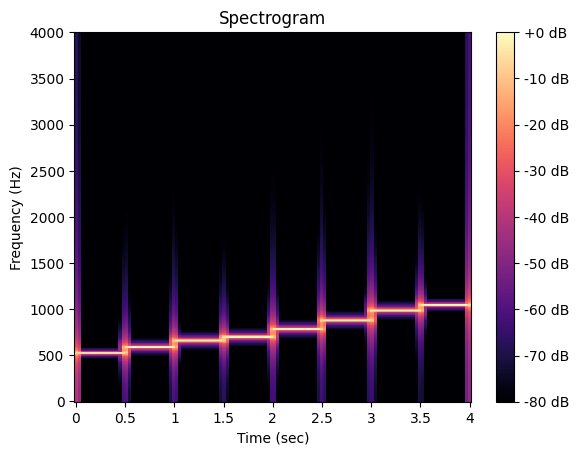

In [47]:
data = data.astype(float)
stft_data = librosa.stft(data, n_fft=1024, hop_length=256) 
stft_db = librosa.amplitude_to_db(np.abs(stft_data), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(stft_db, x_axis='time', y_axis='linear', n_fft=1024, hop_length=256, sr=Fs,ax=ax)
ax.set(title='Spectrogram')
fig.gca().set_xlabel("Time (sec)")
fig.gca().set_ylabel("Frequency (Hz)")
fig.colorbar(img, ax=ax, format="%+2.f dB")

Load MNIST spoken digits, 50 recordings of digits 0-9 by 6 speakers (3000 recordings in all, recorded at 8 kHz). Process and explore dataset.

In [48]:
# C:\Users\CXXXXXXX\OneDrive - Camosun College\Documents\python\free-spoken-digit-dataset-master\recordings
ds = deeplake.load("hub://activeloop/spoken_mnist")

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/spoken_mnist



|

hub://activeloop/spoken_mnist loaded successfully.



In [49]:
# importing data
path = "C:/Users/C0000740/OneDrive - Camosun College/Documents/python/free-spoken-digit-dataset-master"
files = librosa.util.find_files(path, ext=['wav']) 
files = np.asarray(files)

data = []
y = []

# for file in files: 
for (i,file) in enumerate(files):
    print("Processing %d %s" % (i, file))
    linear_data, sr = librosa.load(file, sr = 8000, mono = True)   
    data.append(linear_data)
    #y.append(file[106])     number depends on path of files (106 needed on Joyce's PC)
    y.append(file[106]) 

Processing 0 C:\Users\C0000740\OneDrive - Camosun College\Documents\python\free-spoken-digit-dataset-master\recordings\0_george_0.wav
Processing 1 C:\Users\C0000740\OneDrive - Camosun College\Documents\python\free-spoken-digit-dataset-master\recordings\0_george_1.wav
Processing 2 C:\Users\C0000740\OneDrive - Camosun College\Documents\python\free-spoken-digit-dataset-master\recordings\0_george_10.wav
Processing 3 C:\Users\C0000740\OneDrive - Camosun College\Documents\python\free-spoken-digit-dataset-master\recordings\0_george_11.wav
Processing 4 C:\Users\C0000740\OneDrive - Camosun College\Documents\python\free-spoken-digit-dataset-master\recordings\0_george_12.wav
Processing 5 C:\Users\C0000740\OneDrive - Camosun College\Documents\python\free-spoken-digit-dataset-master\recordings\0_george_13.wav
Processing 6 C:\Users\C0000740\OneDrive - Camosun College\Documents\python\free-spoken-digit-dataset-master\recordings\0_george_14.wav
Processing 7 C:\Users\C0000740\OneDrive - Camosun College

In [51]:
print(file[0:112])
print(file[106]) # verify the character that corresponds to the digit in your pathname

C:\Users\C0000740\OneDrive - Camosun College\Documents\python\free-spoken-digit-dataset-master\recordings\9_ywew
9


In [52]:
print("The number of rows of data = ",len(data))
print("The number of elements in the first row = ", len(data[0]))
print("The number of elements in the second row = ", len(data[1]))

The number of rows of data =  3000
The number of elements in the first row =  2384
The number of elements in the second row =  4727


theo spoke 7


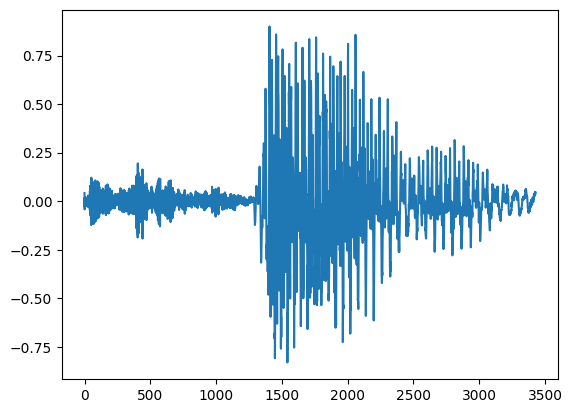

In [53]:
num = 2300 # choose a number from 0 to 2999
audio1 = data[num]
print(f"{ds.speakers[num].numpy()[0]} spoke {ds.labels[num].numpy()[0]}")
audio2 = audio1.astype(np.float32)/32767.0
audio2 = (0.9/max(audio2))*audio2
audio2 = audio2[0:1999999]
plt.plot(audio2)
Fs=8000
data2 = audio1.astype(float)
stft_data = librosa.stft(data2, n_fft=1024, hop_length=256) 
stft_db = librosa.amplitude_to_db(np.abs(stft_data), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(stft_db, x_axis='time', y_axis='linear', n_fft=1024, hop_length=256, sr=Fs,ax=ax)
ax.set(title='Spectrogram')
fig.gca().set_xlabel("Time (sec)")
fig.gca().set_ylabel("Frequency (Hz)")
fig.colorbar(img, ax=ax, format="%+2.f dB")
ipd.Audio(audio2,rate=8000)

Compute means and standard deviations of STFT magnitudes to be used as features for spoken digit classification.

In [54]:
x = []
for i in range(len(data)): # len(data) is 3000, the total number of rows of data, 50 digits per 6 speakers
    absstft = np.abs(librosa.stft(data[i],n_fft=1024, hop_length=256)) # stft function stacks all the FFTs for the overlapping windows of the digit one on top of another
    mean_absstft = np.mean(absstft,axis=1) # axis = 1 means means of row
    std_absstft = np.std(absstft, axis=1)
    x_msd = np.hstack([mean_absstft, std_absstft])
    x.append(x_msd) 
x = np.array(x)
print(x.shape)

(3000, 1026)


Encode digit labels using one hot encoding.

In [55]:
y1h = np.array(y)
y1h = y1h.reshape(-1,1) # reshape into one column
enc = OneHotEncoder()
y1h = enc.fit_transform(y1h).toarray()
print(y1h.shape)
# print some examples of digit number with corresponding one hot encoding
print(y[0], y1h[0])
print(y[417], y1h[417])
print(y[2655],y1h[2655])

(3000, 10)
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
8 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


Define a convolutional neural network to perform spoken digit classification task.

In [56]:
classifier = Sequential()
classifier.add(keras.Input(shape=(1026,1))) # each spoken digit has 513 STFT means and 513 STFT standard deviations
classifier.add(Convolution1D(filters = 128, kernel_size = 6, activation = 'relu'))
classifier.add(Convolution1D(filters = 128, kernel_size = 6, activation = 'relu'))
classifier.add(MaxPooling1D(pool_size = 4))
classifier.add(Dropout(0.5))
classifier.add(Convolution1D(filters = 128, kernel_size = 6, activation = 'relu'))
classifier.add(Convolution1D(filters = 128, kernel_size = 6, activation = 'relu'))
classifier.add(MaxPooling1D(pool_size = 4))
classifier.add(Dropout(0.5))
classifier.add(Flatten())
classifier.add(Dense(units = 64, activation = 'relu'))
classifier.add(Dense(units = 10, activation = 'softmax'))
classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 1021, 128)           │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1016, 128)           │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 254, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 254, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 249, 128)            │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 244, 128)            │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 61, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 61, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7808)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         499,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 796,618 (3.04 MB)

 Trainable params: 796,618 (3.04 MB)

 Non-trainable params: 0 (0.00 B)

Train and test the model.

In [57]:
# divide the data into a training set and a test set
x_train, x_test, y_train, y_test = train_test_split(x,y1h,test_size = 0.25)

In [58]:
# training the model
classifier.fit(x_train, y_train, epochs=15, batch_size=16, validation_split=0.1)
# testing the model
loss, accuracy = classifier.evaluate(x_test, y_test, batch_size=16)
print("Accuracy on test data is ", accuracy)

# saving model
classifier.save('my_model.keras')

Epoch 1/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.3551 - loss: 1.8066 - val_accuracy: 0.7289 - val_loss: 0.8757
Epoch 2/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.6753 - loss: 0.9233 - val_accuracy: 0.8044 - val_loss: 0.6237
Epoch 3/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7857 - loss: 0.5926 - val_accuracy: 0.8356 - val_loss: 0.5123
Epoch 4/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.8393 - loss: 0.4910 - val_accuracy: 0.8889 - val_loss: 0.3175
Epoch 5/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.8929 - loss: 0.3413 - val_accuracy: 0.9333 - val_loss: 0.2533
Epoch 6/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9030 - loss: 0.2904 - val_accuracy: 0.9200 - val_loss: 0.2434
Epoch 7/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.9004 - loss: 0.2770 - val_accuracy: 0.9200 - val_loss: 0.2585
Epoch 8/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.9226 - loss: 0.2200 - val_accu

In [70]:
num = 394 # choose a number from 0 to 2999 # files that produce errors include 1934 and 2085
audio1 = data[num]
print(f"{ds.speakers[num].numpy()[0]} spoke {ds.labels[num].numpy()[0]}")
audio2 = audio1.astype(np.float32)/32767.0
audio2 = (0.9/max(audio2))*audio2
audio2 = audio2[0:1999999]

xtest=[]
absstft = np.abs(librosa.stft(audio2,n_fft=1024, hop_length=256))
mean_absstft = np.mean(absstft,axis=1) # axis = 1 means means of row
std_absstft = np.std(absstft, axis=1)
x_msd = np.hstack([mean_absstft, std_absstft])
xtest.append(x_msd) 
xtest = np.array(xtest)

y_pred = classifier.predict(xtest)
print("Probabilities: ", y_pred)
print("Digit recognized: ",y_pred.argmax())

ipd.Audio(audio2,rate=8000)

jackson spoke 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Probabilities:  [[2.3125359e-10 9.9857378e-01 3.2665362e-16 3.3409145e-16 2.5860173e-14
  1.0255579e-09 9.7384682e-24 2.2184247e-13 7.0879892e-20 1.4261936e-03]]
Digit recognized:  1


In [ ]:
%run spoken_digit_real_time_tester  # speak in a lower voice since training data is from males

Enter Y to Record, N to Exit:  y


Recording...
Finished...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
[[4.1210369e-05 6.0095447e-01 1.4933880e-02 1.7432286e-09 5.2480993e-09
  6.8009103e-07 1.0598978e-17 1.3252877e-10 3.5777047e-17 3.8406983e-01]]
1
